In [2]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [3]:
class IVFDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [4]:
class DNN_Regression(nn.Module):
    def __init__(self, input_dim):
        super(DNN_Regression, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [5]:
def trainer(train_loader, valid_loader, model, config, device):
    
    # TODO try differnet criterion or optimizer 
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    writer = SummaryWriter()
    
    if not os.path.isdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models'):
        os.mkdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models') # Create directory of saving models.
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [6]:
device = 'cpu'

config = {
    'seed': 1322,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-4,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': '/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models/model.ckpt'  # Your model will be saved here.
}

In [7]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [8]:
same_seed(config['seed'])

In [16]:
train_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_x.csv')
train_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_y.csv')
test_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_x.csv')
test_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_y.csv')

In [17]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.10, random_state=42)

In [18]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(112338, 21) (112338, 1)
(12482, 21) (12482, 1)
(31205, 21) (31205, 1)


In [21]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy().ravel()
valid_x = valid_x.to_numpy()
valid_y = valid_y.to_numpy().ravel()
test_x  = test_x.to_numpy()
test_y = test_y.to_numpy().ravel()

In [22]:
train_dataset = IVFDataset(train_x, train_y)
valid_dataset = IVFDataset(valid_x, valid_y)
test_dataset = IVFDataset(test_x)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [25]:
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)

In [29]:
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 265.00it/s, loss=0.113]


Epoch [1/1000]: Train loss: 0.1114, Valid loss: 0.1092
Saving model with loss 0.109...


Epoch [2/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 261.78it/s, loss=0.172]


Epoch [2/1000]: Train loss: 0.1112, Valid loss: 0.1090
Saving model with loss 0.109...


Epoch [3/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 268.77it/s, loss=0.128]


Epoch [3/1000]: Train loss: 0.1109, Valid loss: 0.1091


Epoch [4/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 277.79it/s, loss=0.0721]


Epoch [4/1000]: Train loss: 0.1107, Valid loss: 0.1085
Saving model with loss 0.108...


Epoch [5/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 262.94it/s, loss=0.0927]


Epoch [5/1000]: Train loss: 0.1105, Valid loss: 0.1083
Saving model with loss 0.108...


Epoch [6/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 289.76it/s, loss=0.0968]


Epoch [6/1000]: Train loss: 0.1103, Valid loss: 0.1080
Saving model with loss 0.108...


Epoch [7/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 262.83it/s, loss=0.113]


Epoch [7/1000]: Train loss: 0.1100, Valid loss: 0.1080
Saving model with loss 0.108...


Epoch [8/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 279.10it/s, loss=0.132]


Epoch [8/1000]: Train loss: 0.1098, Valid loss: 0.1076
Saving model with loss 0.108...


Epoch [9/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 248.90it/s, loss=0.114]


Epoch [9/1000]: Train loss: 0.1096, Valid loss: 0.1074
Saving model with loss 0.107...


Epoch [10/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 275.80it/s, loss=0.112]


Epoch [10/1000]: Train loss: 0.1094, Valid loss: 0.1072
Saving model with loss 0.107...


Epoch [11/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 251.93it/s, loss=0.109]


Epoch [11/1000]: Train loss: 0.1092, Valid loss: 0.1071
Saving model with loss 0.107...


Epoch [12/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 287.92it/s, loss=0.0726]


Epoch [12/1000]: Train loss: 0.1089, Valid loss: 0.1066
Saving model with loss 0.107...


Epoch [13/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 289.78it/s, loss=0.089]


Epoch [13/1000]: Train loss: 0.1087, Valid loss: 0.1068


Epoch [14/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 291.59it/s, loss=0.0908]


Epoch [14/1000]: Train loss: 0.1085, Valid loss: 0.1064
Saving model with loss 0.106...


Epoch [15/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 286.86it/s, loss=0.119]


Epoch [15/1000]: Train loss: 0.1083, Valid loss: 0.1064
Saving model with loss 0.106...


Epoch [16/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 264.86it/s, loss=0.122]


Epoch [16/1000]: Train loss: 0.1081, Valid loss: 0.1061
Saving model with loss 0.106...


Epoch [17/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 265.39it/s, loss=0.113]


Epoch [17/1000]: Train loss: 0.1078, Valid loss: 0.1056
Saving model with loss 0.106...


Epoch [18/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 259.89it/s, loss=0.0938]


Epoch [18/1000]: Train loss: 0.1076, Valid loss: 0.1054
Saving model with loss 0.105...


Epoch [19/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 231.18it/s, loss=0.091]


Epoch [19/1000]: Train loss: 0.1074, Valid loss: 0.1052
Saving model with loss 0.105...


Epoch [20/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 262.81it/s, loss=0.126]


Epoch [20/1000]: Train loss: 0.1072, Valid loss: 0.1051
Saving model with loss 0.105...


Epoch [21/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 285.04it/s, loss=0.123]


Epoch [21/1000]: Train loss: 0.1070, Valid loss: 0.1049
Saving model with loss 0.105...


Epoch [22/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 272.68it/s, loss=0.14]


Epoch [22/1000]: Train loss: 0.1068, Valid loss: 0.1047
Saving model with loss 0.105...


Epoch [23/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 281.08it/s, loss=0.0889]


Epoch [23/1000]: Train loss: 0.1066, Valid loss: 0.1044
Saving model with loss 0.104...


Epoch [24/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 262.02it/s, loss=0.0862]


Epoch [24/1000]: Train loss: 0.1064, Valid loss: 0.1043
Saving model with loss 0.104...


Epoch [25/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 289.20it/s, loss=0.0838]


Epoch [25/1000]: Train loss: 0.1062, Valid loss: 0.1041
Saving model with loss 0.104...


Epoch [26/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 266.82it/s, loss=0.0808]


Epoch [26/1000]: Train loss: 0.1059, Valid loss: 0.1039
Saving model with loss 0.104...


Epoch [27/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 262.51it/s, loss=0.124]


Epoch [27/1000]: Train loss: 0.1058, Valid loss: 0.1039


Epoch [28/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 282.60it/s, loss=0.114]


Epoch [28/1000]: Train loss: 0.1056, Valid loss: 0.1035
Saving model with loss 0.103...


Epoch [29/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 268.45it/s, loss=0.109]


Epoch [29/1000]: Train loss: 0.1053, Valid loss: 0.1035


Epoch [30/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 277.76it/s, loss=0.11]


Epoch [30/1000]: Train loss: 0.1051, Valid loss: 0.1031
Saving model with loss 0.103...


Epoch [31/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 243.70it/s, loss=0.117]


Epoch [31/1000]: Train loss: 0.1049, Valid loss: 0.1028
Saving model with loss 0.103...


Epoch [32/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 279.06it/s, loss=0.102]


Epoch [32/1000]: Train loss: 0.1047, Valid loss: 0.1028
Saving model with loss 0.103...


Epoch [33/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 260.67it/s, loss=0.128]


Epoch [33/1000]: Train loss: 0.1045, Valid loss: 0.1026
Saving model with loss 0.103...


Epoch [34/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 293.61it/s, loss=0.0842]


Epoch [34/1000]: Train loss: 0.1043, Valid loss: 0.1020
Saving model with loss 0.102...


Epoch [35/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 252.12it/s, loss=0.101]


Epoch [35/1000]: Train loss: 0.1040, Valid loss: 0.1020
Saving model with loss 0.102...


Epoch [36/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 255.21it/s, loss=0.102]


Epoch [36/1000]: Train loss: 0.1036, Valid loss: 0.1014
Saving model with loss 0.101...


Epoch [37/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 263.70it/s, loss=0.102]


Epoch [37/1000]: Train loss: 0.1030, Valid loss: 0.1008
Saving model with loss 0.101...


Epoch [38/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 291.31it/s, loss=0.122]


Epoch [38/1000]: Train loss: 0.1024, Valid loss: 0.1002
Saving model with loss 0.100...


Epoch [39/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 240.83it/s, loss=0.0898]


Epoch [39/1000]: Train loss: 0.1019, Valid loss: 0.0997
Saving model with loss 0.100...


Epoch [40/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 273.39it/s, loss=0.0626]


Epoch [40/1000]: Train loss: 0.1014, Valid loss: 0.0995
Saving model with loss 0.100...


Epoch [41/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 266.43it/s, loss=0.0949]


Epoch [41/1000]: Train loss: 0.1011, Valid loss: 0.0992
Saving model with loss 0.099...


Epoch [42/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 259.14it/s, loss=0.0927]


Epoch [42/1000]: Train loss: 0.1008, Valid loss: 0.0987
Saving model with loss 0.099...


Epoch [43/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 270.04it/s, loss=0.089]


Epoch [43/1000]: Train loss: 0.1005, Valid loss: 0.0985
Saving model with loss 0.098...


Epoch [44/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:02<00:00, 215.06it/s, loss=0.111]


Epoch [44/1000]: Train loss: 0.1003, Valid loss: 0.0982
Saving model with loss 0.098...


Epoch [45/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 260.77it/s, loss=0.0716]


Epoch [45/1000]: Train loss: 0.1000, Valid loss: 0.0979
Saving model with loss 0.098...


Epoch [46/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 266.25it/s, loss=0.0914]


Epoch [46/1000]: Train loss: 0.0997, Valid loss: 0.0977
Saving model with loss 0.098...


Epoch [47/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 292.65it/s, loss=0.0722]


Epoch [47/1000]: Train loss: 0.0995, Valid loss: 0.0975
Saving model with loss 0.098...


Epoch [48/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 251.04it/s, loss=0.0945]


Epoch [48/1000]: Train loss: 0.0992, Valid loss: 0.0972
Saving model with loss 0.097...


Epoch [49/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 239.21it/s, loss=0.119]


Epoch [49/1000]: Train loss: 0.0990, Valid loss: 0.0972


Epoch [50/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 240.95it/s, loss=0.0571]


Epoch [50/1000]: Train loss: 0.0987, Valid loss: 0.0967
Saving model with loss 0.097...


Epoch [51/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 292.37it/s, loss=0.146]


Epoch [51/1000]: Train loss: 0.0985, Valid loss: 0.0965
Saving model with loss 0.096...


Epoch [52/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 241.11it/s, loss=0.0756]


Epoch [52/1000]: Train loss: 0.0982, Valid loss: 0.0962
Saving model with loss 0.096...


Epoch [53/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 267.06it/s, loss=0.092]


Epoch [53/1000]: Train loss: 0.0980, Valid loss: 0.0961
Saving model with loss 0.096...


Epoch [54/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 258.23it/s, loss=0.099]


Epoch [54/1000]: Train loss: 0.0977, Valid loss: 0.0957
Saving model with loss 0.096...


Epoch [55/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 257.94it/s, loss=0.0884]


Epoch [55/1000]: Train loss: 0.0975, Valid loss: 0.0955
Saving model with loss 0.095...


Epoch [56/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 262.51it/s, loss=0.0989]


Epoch [56/1000]: Train loss: 0.0973, Valid loss: 0.0952
Saving model with loss 0.095...


Epoch [57/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 236.62it/s, loss=0.085]


Epoch [57/1000]: Train loss: 0.0970, Valid loss: 0.0952
Saving model with loss 0.095...


Epoch [58/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 272.62it/s, loss=0.0977]


Epoch [58/1000]: Train loss: 0.0968, Valid loss: 0.0949
Saving model with loss 0.095...


Epoch [59/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 239.73it/s, loss=0.141]


Epoch [59/1000]: Train loss: 0.0966, Valid loss: 0.0946
Saving model with loss 0.095...


Epoch [60/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 266.99it/s, loss=0.103]


Epoch [60/1000]: Train loss: 0.0963, Valid loss: 0.0942
Saving model with loss 0.094...


Epoch [61/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 237.33it/s, loss=0.0742]


Epoch [61/1000]: Train loss: 0.0961, Valid loss: 0.0942
Saving model with loss 0.094...


Epoch [62/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 279.69it/s, loss=0.0802]


Epoch [62/1000]: Train loss: 0.0959, Valid loss: 0.0938
Saving model with loss 0.094...


Epoch [63/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 263.13it/s, loss=0.0947]


Epoch [63/1000]: Train loss: 0.0956, Valid loss: 0.0936
Saving model with loss 0.094...


Epoch [64/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 266.50it/s, loss=0.0787]


Epoch [64/1000]: Train loss: 0.0954, Valid loss: 0.0934
Saving model with loss 0.093...


Epoch [65/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 252.38it/s, loss=0.0809]


Epoch [65/1000]: Train loss: 0.0952, Valid loss: 0.0934
Saving model with loss 0.093...


Epoch [66/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 285.41it/s, loss=0.102]


Epoch [66/1000]: Train loss: 0.0950, Valid loss: 0.0930
Saving model with loss 0.093...


Epoch [67/1000]: 100%|██████████████████████████████████████████████| 439/439 [00:01<00:00, 260.26it/s, loss=0.09]


Epoch [67/1000]: Train loss: 0.0947, Valid loss: 0.0929
Saving model with loss 0.093...


Epoch [68/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 292.23it/s, loss=0.0905]


Epoch [68/1000]: Train loss: 0.0945, Valid loss: 0.0926
Saving model with loss 0.093...


Epoch [69/1000]: 100%|███████████████████████████████████████████████| 439/439 [00:01<00:00, 273.33it/s, loss=0.1]


Epoch [69/1000]: Train loss: 0.0943, Valid loss: 0.0923
Saving model with loss 0.092...


Epoch [70/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 290.87it/s, loss=0.0802]


Epoch [70/1000]: Train loss: 0.0941, Valid loss: 0.0921
Saving model with loss 0.092...


Epoch [71/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 275.79it/s, loss=0.0986]


Epoch [71/1000]: Train loss: 0.0938, Valid loss: 0.0920
Saving model with loss 0.092...


Epoch [72/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 273.37it/s, loss=0.0689]


Epoch [72/1000]: Train loss: 0.0936, Valid loss: 0.0917
Saving model with loss 0.092...


Epoch [73/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 290.32it/s, loss=0.0927]


Epoch [73/1000]: Train loss: 0.0934, Valid loss: 0.0915
Saving model with loss 0.092...


Epoch [74/1000]: 100%|███████████████████████████████████████████████| 439/439 [00:01<00:00, 262.76it/s, loss=0.1]


Epoch [74/1000]: Train loss: 0.0932, Valid loss: 0.0912
Saving model with loss 0.091...


Epoch [75/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 264.61it/s, loss=0.0861]


Epoch [75/1000]: Train loss: 0.0930, Valid loss: 0.0913


Epoch [76/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 231.68it/s, loss=0.0877]


Epoch [76/1000]: Train loss: 0.0927, Valid loss: 0.0909
Saving model with loss 0.091...


Epoch [77/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 272.29it/s, loss=0.0762]


Epoch [77/1000]: Train loss: 0.0925, Valid loss: 0.0907
Saving model with loss 0.091...


Epoch [78/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 249.50it/s, loss=0.0691]


Epoch [78/1000]: Train loss: 0.0923, Valid loss: 0.0903
Saving model with loss 0.090...


Epoch [79/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 282.68it/s, loss=0.103]


Epoch [79/1000]: Train loss: 0.0921, Valid loss: 0.0903


Epoch [80/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 254.09it/s, loss=0.0912]


Epoch [80/1000]: Train loss: 0.0919, Valid loss: 0.0900
Saving model with loss 0.090...


Epoch [81/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 290.14it/s, loss=0.0846]


Epoch [81/1000]: Train loss: 0.0916, Valid loss: 0.0898
Saving model with loss 0.090...


Epoch [82/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 246.73it/s, loss=0.119]


Epoch [82/1000]: Train loss: 0.0914, Valid loss: 0.0896
Saving model with loss 0.090...


Epoch [83/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 279.91it/s, loss=0.0843]


Epoch [83/1000]: Train loss: 0.0912, Valid loss: 0.0893
Saving model with loss 0.089...


Epoch [84/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 270.28it/s, loss=0.0889]


Epoch [84/1000]: Train loss: 0.0910, Valid loss: 0.0891
Saving model with loss 0.089...


Epoch [85/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 248.67it/s, loss=0.0972]


Epoch [85/1000]: Train loss: 0.0908, Valid loss: 0.0888
Saving model with loss 0.089...


Epoch [86/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 276.84it/s, loss=0.0739]


Epoch [86/1000]: Train loss: 0.0905, Valid loss: 0.0886
Saving model with loss 0.089...


Epoch [87/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 249.81it/s, loss=0.0891]


Epoch [87/1000]: Train loss: 0.0903, Valid loss: 0.0885
Saving model with loss 0.089...


Epoch [88/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 279.28it/s, loss=0.0961]


Epoch [88/1000]: Train loss: 0.0901, Valid loss: 0.0884
Saving model with loss 0.088...


Epoch [89/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 255.83it/s, loss=0.124]


Epoch [89/1000]: Train loss: 0.0899, Valid loss: 0.0880
Saving model with loss 0.088...


Epoch [90/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 275.24it/s, loss=0.0781]


Epoch [90/1000]: Train loss: 0.0896, Valid loss: 0.0877
Saving model with loss 0.088...


Epoch [91/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 261.08it/s, loss=0.132]


Epoch [91/1000]: Train loss: 0.0894, Valid loss: 0.0875
Saving model with loss 0.088...


Epoch [92/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 276.38it/s, loss=0.0731]


Epoch [92/1000]: Train loss: 0.0892, Valid loss: 0.0874
Saving model with loss 0.087...


Epoch [93/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 246.47it/s, loss=0.119]


Epoch [93/1000]: Train loss: 0.0890, Valid loss: 0.0871
Saving model with loss 0.087...


Epoch [94/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 238.04it/s, loss=0.0877]


Epoch [94/1000]: Train loss: 0.0887, Valid loss: 0.0868
Saving model with loss 0.087...


Epoch [95/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 236.88it/s, loss=0.0745]


Epoch [95/1000]: Train loss: 0.0885, Valid loss: 0.0865
Saving model with loss 0.087...


Epoch [96/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 277.06it/s, loss=0.0626]


Epoch [96/1000]: Train loss: 0.0882, Valid loss: 0.0863
Saving model with loss 0.086...


Epoch [97/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 281.53it/s, loss=0.0829]


Epoch [97/1000]: Train loss: 0.0880, Valid loss: 0.0861
Saving model with loss 0.086...


Epoch [98/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 292.23it/s, loss=0.0842]


Epoch [98/1000]: Train loss: 0.0878, Valid loss: 0.0860
Saving model with loss 0.086...


Epoch [99/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 281.44it/s, loss=0.0725]


Epoch [99/1000]: Train loss: 0.0875, Valid loss: 0.0856
Saving model with loss 0.086...


Epoch [100/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.18it/s, loss=0.0802]


Epoch [100/1000]: Train loss: 0.0873, Valid loss: 0.0855
Saving model with loss 0.085...


Epoch [101/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 284.02it/s, loss=0.0914]


Epoch [101/1000]: Train loss: 0.0871, Valid loss: 0.0850
Saving model with loss 0.085...


Epoch [102/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 249.09it/s, loss=0.0937]


Epoch [102/1000]: Train loss: 0.0869, Valid loss: 0.0849
Saving model with loss 0.085...


Epoch [103/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 298.77it/s, loss=0.098]


Epoch [103/1000]: Train loss: 0.0866, Valid loss: 0.0848
Saving model with loss 0.085...


Epoch [104/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.40it/s, loss=0.0974]


Epoch [104/1000]: Train loss: 0.0864, Valid loss: 0.0844
Saving model with loss 0.084...


Epoch [105/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.98it/s, loss=0.0698]


Epoch [105/1000]: Train loss: 0.0861, Valid loss: 0.0843
Saving model with loss 0.084...


Epoch [106/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 253.07it/s, loss=0.0622]


Epoch [106/1000]: Train loss: 0.0859, Valid loss: 0.0841
Saving model with loss 0.084...


Epoch [107/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.49it/s, loss=0.0568]


Epoch [107/1000]: Train loss: 0.0856, Valid loss: 0.0838
Saving model with loss 0.084...


Epoch [108/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 250.27it/s, loss=0.073]


Epoch [108/1000]: Train loss: 0.0854, Valid loss: 0.0836
Saving model with loss 0.084...


Epoch [109/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.34it/s, loss=0.0903]


Epoch [109/1000]: Train loss: 0.0852, Valid loss: 0.0833
Saving model with loss 0.083...


Epoch [110/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 261.07it/s, loss=0.081]


Epoch [110/1000]: Train loss: 0.0849, Valid loss: 0.0832
Saving model with loss 0.083...


Epoch [111/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 255.23it/s, loss=0.111]


Epoch [111/1000]: Train loss: 0.0847, Valid loss: 0.0828
Saving model with loss 0.083...


Epoch [112/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 277.29it/s, loss=0.107]


Epoch [112/1000]: Train loss: 0.0844, Valid loss: 0.0827
Saving model with loss 0.083...


Epoch [113/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 245.20it/s, loss=0.0824]


Epoch [113/1000]: Train loss: 0.0842, Valid loss: 0.0822
Saving model with loss 0.082...


Epoch [114/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.55it/s, loss=0.0801]


Epoch [114/1000]: Train loss: 0.0839, Valid loss: 0.0822
Saving model with loss 0.082...


Epoch [115/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.78it/s, loss=0.0759]


Epoch [115/1000]: Train loss: 0.0837, Valid loss: 0.0818
Saving model with loss 0.082...


Epoch [116/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 273.61it/s, loss=0.0923]


Epoch [116/1000]: Train loss: 0.0834, Valid loss: 0.0815
Saving model with loss 0.082...


Epoch [117/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.33it/s, loss=0.0908]


Epoch [117/1000]: Train loss: 0.0832, Valid loss: 0.0814
Saving model with loss 0.081...


Epoch [118/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.92it/s, loss=0.0989]


Epoch [118/1000]: Train loss: 0.0829, Valid loss: 0.0810
Saving model with loss 0.081...


Epoch [119/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 225.19it/s, loss=0.079]


Epoch [119/1000]: Train loss: 0.0826, Valid loss: 0.0807
Saving model with loss 0.081...


Epoch [120/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.16it/s, loss=0.0724]


Epoch [120/1000]: Train loss: 0.0824, Valid loss: 0.0805
Saving model with loss 0.080...


Epoch [121/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.77it/s, loss=0.0563]


Epoch [121/1000]: Train loss: 0.0821, Valid loss: 0.0802
Saving model with loss 0.080...


Epoch [122/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.38it/s, loss=0.0769]


Epoch [122/1000]: Train loss: 0.0818, Valid loss: 0.0800
Saving model with loss 0.080...


Epoch [123/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 248.30it/s, loss=0.0981]


Epoch [123/1000]: Train loss: 0.0816, Valid loss: 0.0799
Saving model with loss 0.080...


Epoch [124/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.97it/s, loss=0.0634]


Epoch [124/1000]: Train loss: 0.0813, Valid loss: 0.0795
Saving model with loss 0.079...


Epoch [125/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.18it/s, loss=0.0903]


Epoch [125/1000]: Train loss: 0.0811, Valid loss: 0.0793
Saving model with loss 0.079...


Epoch [126/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.37it/s, loss=0.0601]


Epoch [126/1000]: Train loss: 0.0808, Valid loss: 0.0790
Saving model with loss 0.079...


Epoch [127/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.02it/s, loss=0.0713]


Epoch [127/1000]: Train loss: 0.0805, Valid loss: 0.0787
Saving model with loss 0.079...


Epoch [128/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.47it/s, loss=0.0733]


Epoch [128/1000]: Train loss: 0.0803, Valid loss: 0.0784
Saving model with loss 0.078...


Epoch [129/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.45it/s, loss=0.0746]


Epoch [129/1000]: Train loss: 0.0800, Valid loss: 0.0781
Saving model with loss 0.078...


Epoch [130/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 250.19it/s, loss=0.0842]


Epoch [130/1000]: Train loss: 0.0797, Valid loss: 0.0780
Saving model with loss 0.078...


Epoch [131/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 269.91it/s, loss=0.0702]


Epoch [131/1000]: Train loss: 0.0794, Valid loss: 0.0776
Saving model with loss 0.078...


Epoch [132/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.13it/s, loss=0.0627]


Epoch [132/1000]: Train loss: 0.0792, Valid loss: 0.0775
Saving model with loss 0.077...


Epoch [133/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 278.07it/s, loss=0.075]


Epoch [133/1000]: Train loss: 0.0789, Valid loss: 0.0772
Saving model with loss 0.077...


Epoch [134/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 264.57it/s, loss=0.11]


Epoch [134/1000]: Train loss: 0.0786, Valid loss: 0.0769
Saving model with loss 0.077...


Epoch [135/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 268.30it/s, loss=0.0515]


Epoch [135/1000]: Train loss: 0.0783, Valid loss: 0.0766
Saving model with loss 0.077...


Epoch [136/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 241.64it/s, loss=0.106]


Epoch [136/1000]: Train loss: 0.0781, Valid loss: 0.0763
Saving model with loss 0.076...


Epoch [137/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.62it/s, loss=0.0767]


Epoch [137/1000]: Train loss: 0.0778, Valid loss: 0.0761
Saving model with loss 0.076...


Epoch [138/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 242.78it/s, loss=0.0826]


Epoch [138/1000]: Train loss: 0.0775, Valid loss: 0.0758
Saving model with loss 0.076...


Epoch [139/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.62it/s, loss=0.0725]


Epoch [139/1000]: Train loss: 0.0772, Valid loss: 0.0755
Saving model with loss 0.076...


Epoch [140/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.39it/s, loss=0.0953]


Epoch [140/1000]: Train loss: 0.0770, Valid loss: 0.0753
Saving model with loss 0.075...


Epoch [141/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 250.13it/s, loss=0.0715]


Epoch [141/1000]: Train loss: 0.0767, Valid loss: 0.0750
Saving model with loss 0.075...


Epoch [142/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.45it/s, loss=0.0814]


Epoch [142/1000]: Train loss: 0.0764, Valid loss: 0.0746
Saving model with loss 0.075...


Epoch [143/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.48it/s, loss=0.0953]


Epoch [143/1000]: Train loss: 0.0761, Valid loss: 0.0744
Saving model with loss 0.074...


Epoch [144/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 256.35it/s, loss=0.0658]


Epoch [144/1000]: Train loss: 0.0758, Valid loss: 0.0741
Saving model with loss 0.074...


Epoch [145/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.21it/s, loss=0.0692]


Epoch [145/1000]: Train loss: 0.0755, Valid loss: 0.0738
Saving model with loss 0.074...


Epoch [146/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.08it/s, loss=0.0723]


Epoch [146/1000]: Train loss: 0.0752, Valid loss: 0.0734
Saving model with loss 0.073...


Epoch [147/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 250.46it/s, loss=0.0686]


Epoch [147/1000]: Train loss: 0.0749, Valid loss: 0.0732
Saving model with loss 0.073...


Epoch [148/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 273.88it/s, loss=0.107]


Epoch [148/1000]: Train loss: 0.0747, Valid loss: 0.0730
Saving model with loss 0.073...


Epoch [149/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 247.06it/s, loss=0.0887]


Epoch [149/1000]: Train loss: 0.0744, Valid loss: 0.0726
Saving model with loss 0.073...


Epoch [150/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.36it/s, loss=0.0801]


Epoch [150/1000]: Train loss: 0.0741, Valid loss: 0.0723
Saving model with loss 0.072...


Epoch [151/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.22it/s, loss=0.0759]


Epoch [151/1000]: Train loss: 0.0738, Valid loss: 0.0721
Saving model with loss 0.072...


Epoch [152/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.18it/s, loss=0.0645]


Epoch [152/1000]: Train loss: 0.0735, Valid loss: 0.0718
Saving model with loss 0.072...


Epoch [153/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.86it/s, loss=0.0763]


Epoch [153/1000]: Train loss: 0.0732, Valid loss: 0.0714
Saving model with loss 0.071...


Epoch [154/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 281.41it/s, loss=0.0493]


Epoch [154/1000]: Train loss: 0.0729, Valid loss: 0.0712
Saving model with loss 0.071...


Epoch [155/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.57it/s, loss=0.0601]


Epoch [155/1000]: Train loss: 0.0726, Valid loss: 0.0709
Saving model with loss 0.071...


Epoch [156/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.49it/s, loss=0.0842]


Epoch [156/1000]: Train loss: 0.0723, Valid loss: 0.0706
Saving model with loss 0.071...


Epoch [157/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.59it/s, loss=0.0691]


Epoch [157/1000]: Train loss: 0.0720, Valid loss: 0.0703
Saving model with loss 0.070...


Epoch [158/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.08it/s, loss=0.0997]


Epoch [158/1000]: Train loss: 0.0717, Valid loss: 0.0701
Saving model with loss 0.070...


Epoch [159/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.48it/s, loss=0.0621]


Epoch [159/1000]: Train loss: 0.0714, Valid loss: 0.0697
Saving model with loss 0.070...


Epoch [160/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 250.03it/s, loss=0.0617]


Epoch [160/1000]: Train loss: 0.0711, Valid loss: 0.0693
Saving model with loss 0.069...


Epoch [161/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.65it/s, loss=0.0782]


Epoch [161/1000]: Train loss: 0.0708, Valid loss: 0.0691
Saving model with loss 0.069...


Epoch [162/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.48it/s, loss=0.0705]


Epoch [162/1000]: Train loss: 0.0705, Valid loss: 0.0687
Saving model with loss 0.069...


Epoch [163/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.94it/s, loss=0.0606]


Epoch [163/1000]: Train loss: 0.0702, Valid loss: 0.0686
Saving model with loss 0.069...


Epoch [164/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.39it/s, loss=0.0608]


Epoch [164/1000]: Train loss: 0.0699, Valid loss: 0.0682
Saving model with loss 0.068...


Epoch [165/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.23it/s, loss=0.0852]


Epoch [165/1000]: Train loss: 0.0696, Valid loss: 0.0679
Saving model with loss 0.068...


Epoch [166/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.57it/s, loss=0.0901]


Epoch [166/1000]: Train loss: 0.0693, Valid loss: 0.0676
Saving model with loss 0.068...


Epoch [167/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 278.33it/s, loss=0.0732]


Epoch [167/1000]: Train loss: 0.0690, Valid loss: 0.0674
Saving model with loss 0.067...


Epoch [168/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 269.80it/s, loss=0.0936]


Epoch [168/1000]: Train loss: 0.0687, Valid loss: 0.0671
Saving model with loss 0.067...


Epoch [169/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 241.08it/s, loss=0.0685]


Epoch [169/1000]: Train loss: 0.0683, Valid loss: 0.0667
Saving model with loss 0.067...


Epoch [170/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 273.82it/s, loss=0.0896]


Epoch [170/1000]: Train loss: 0.0680, Valid loss: 0.0663
Saving model with loss 0.066...


Epoch [171/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.89it/s, loss=0.0848]


Epoch [171/1000]: Train loss: 0.0677, Valid loss: 0.0661
Saving model with loss 0.066...


Epoch [172/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.58it/s, loss=0.0574]


Epoch [172/1000]: Train loss: 0.0674, Valid loss: 0.0657
Saving model with loss 0.066...


Epoch [173/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 245.20it/s, loss=0.0554]


Epoch [173/1000]: Train loss: 0.0671, Valid loss: 0.0655
Saving model with loss 0.065...


Epoch [174/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 244.73it/s, loss=0.0543]


Epoch [174/1000]: Train loss: 0.0668, Valid loss: 0.0651
Saving model with loss 0.065...


Epoch [175/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.59it/s, loss=0.0682]


Epoch [175/1000]: Train loss: 0.0665, Valid loss: 0.0648
Saving model with loss 0.065...


Epoch [176/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 301.96it/s, loss=0.0506]


Epoch [176/1000]: Train loss: 0.0661, Valid loss: 0.0646
Saving model with loss 0.065...


Epoch [177/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 237.60it/s, loss=0.0632]


Epoch [177/1000]: Train loss: 0.0658, Valid loss: 0.0643
Saving model with loss 0.064...


Epoch [178/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 273.45it/s, loss=0.0586]


Epoch [178/1000]: Train loss: 0.0655, Valid loss: 0.0639
Saving model with loss 0.064...


Epoch [179/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.19it/s, loss=0.0587]


Epoch [179/1000]: Train loss: 0.0652, Valid loss: 0.0635
Saving model with loss 0.064...


Epoch [180/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 280.72it/s, loss=0.05]


Epoch [180/1000]: Train loss: 0.0649, Valid loss: 0.0632
Saving model with loss 0.063...


Epoch [181/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 282.80it/s, loss=0.0508]


Epoch [181/1000]: Train loss: 0.0646, Valid loss: 0.0630
Saving model with loss 0.063...


Epoch [182/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 293.88it/s, loss=0.0602]


Epoch [182/1000]: Train loss: 0.0642, Valid loss: 0.0626
Saving model with loss 0.063...


Epoch [183/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.96it/s, loss=0.0928]


Epoch [183/1000]: Train loss: 0.0639, Valid loss: 0.0623
Saving model with loss 0.062...


Epoch [184/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.50it/s, loss=0.0472]


Epoch [184/1000]: Train loss: 0.0636, Valid loss: 0.0621
Saving model with loss 0.062...


Epoch [185/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 263.50it/s, loss=0.05]


Epoch [185/1000]: Train loss: 0.0633, Valid loss: 0.0618
Saving model with loss 0.062...


Epoch [186/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 237.46it/s, loss=0.0919]


Epoch [186/1000]: Train loss: 0.0630, Valid loss: 0.0614
Saving model with loss 0.061...


Epoch [187/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.77it/s, loss=0.0732]


Epoch [187/1000]: Train loss: 0.0627, Valid loss: 0.0611
Saving model with loss 0.061...


Epoch [188/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 247.17it/s, loss=0.0607]


Epoch [188/1000]: Train loss: 0.0623, Valid loss: 0.0607
Saving model with loss 0.061...


Epoch [189/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.09it/s, loss=0.0453]


Epoch [189/1000]: Train loss: 0.0620, Valid loss: 0.0605
Saving model with loss 0.060...


Epoch [190/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 247.46it/s, loss=0.0718]


Epoch [190/1000]: Train loss: 0.0617, Valid loss: 0.0603
Saving model with loss 0.060...


Epoch [191/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 291.56it/s, loss=0.0532]


Epoch [191/1000]: Train loss: 0.0614, Valid loss: 0.0600
Saving model with loss 0.060...


Epoch [192/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 269.20it/s, loss=0.0432]


Epoch [192/1000]: Train loss: 0.0611, Valid loss: 0.0598
Saving model with loss 0.060...


Epoch [193/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.94it/s, loss=0.0538]


Epoch [193/1000]: Train loss: 0.0608, Valid loss: 0.0593
Saving model with loss 0.059...


Epoch [194/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 239.59it/s, loss=0.06]


Epoch [194/1000]: Train loss: 0.0604, Valid loss: 0.0589
Saving model with loss 0.059...


Epoch [195/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 277.26it/s, loss=0.0677]


Epoch [195/1000]: Train loss: 0.0601, Valid loss: 0.0588
Saving model with loss 0.059...


Epoch [196/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 284.72it/s, loss=0.0789]


Epoch [196/1000]: Train loss: 0.0598, Valid loss: 0.0583
Saving model with loss 0.058...


Epoch [197/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 251.88it/s, loss=0.04]


Epoch [197/1000]: Train loss: 0.0595, Valid loss: 0.0580
Saving model with loss 0.058...


Epoch [198/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.16it/s, loss=0.0626]


Epoch [198/1000]: Train loss: 0.0592, Valid loss: 0.0577
Saving model with loss 0.058...


Epoch [199/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 242.15it/s, loss=0.0692]


Epoch [199/1000]: Train loss: 0.0589, Valid loss: 0.0574
Saving model with loss 0.057...


Epoch [200/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.99it/s, loss=0.0413]


Epoch [200/1000]: Train loss: 0.0585, Valid loss: 0.0572
Saving model with loss 0.057...


Epoch [201/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.28it/s, loss=0.0603]


Epoch [201/1000]: Train loss: 0.0582, Valid loss: 0.0568
Saving model with loss 0.057...


Epoch [202/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.68it/s, loss=0.0513]


Epoch [202/1000]: Train loss: 0.0579, Valid loss: 0.0565
Saving model with loss 0.056...


Epoch [203/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 255.39it/s, loss=0.0787]


Epoch [203/1000]: Train loss: 0.0576, Valid loss: 0.0561
Saving model with loss 0.056...


Epoch [204/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.90it/s, loss=0.0715]


Epoch [204/1000]: Train loss: 0.0573, Valid loss: 0.0558
Saving model with loss 0.056...


Epoch [205/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 255.50it/s, loss=0.0376]


Epoch [205/1000]: Train loss: 0.0570, Valid loss: 0.0556
Saving model with loss 0.056...


Epoch [206/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.39it/s, loss=0.0615]


Epoch [206/1000]: Train loss: 0.0567, Valid loss: 0.0553
Saving model with loss 0.055...


Epoch [207/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 237.98it/s, loss=0.0369]


Epoch [207/1000]: Train loss: 0.0564, Valid loss: 0.0550
Saving model with loss 0.055...


Epoch [208/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.56it/s, loss=0.0461]


Epoch [208/1000]: Train loss: 0.0561, Valid loss: 0.0547
Saving model with loss 0.055...


Epoch [209/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.07it/s, loss=0.0549]


Epoch [209/1000]: Train loss: 0.0558, Valid loss: 0.0543
Saving model with loss 0.054...


Epoch [210/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.73it/s, loss=0.0586]


Epoch [210/1000]: Train loss: 0.0555, Valid loss: 0.0540
Saving model with loss 0.054...


Epoch [211/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 252.20it/s, loss=0.0531]


Epoch [211/1000]: Train loss: 0.0552, Valid loss: 0.0537
Saving model with loss 0.054...


Epoch [212/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.99it/s, loss=0.0554]


Epoch [212/1000]: Train loss: 0.0549, Valid loss: 0.0534
Saving model with loss 0.053...


Epoch [213/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.67it/s, loss=0.0446]


Epoch [213/1000]: Train loss: 0.0546, Valid loss: 0.0533
Saving model with loss 0.053...


Epoch [214/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.94it/s, loss=0.0385]


Epoch [214/1000]: Train loss: 0.0543, Valid loss: 0.0530
Saving model with loss 0.053...


Epoch [215/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 278.11it/s, loss=0.0658]


Epoch [215/1000]: Train loss: 0.0540, Valid loss: 0.0527
Saving model with loss 0.053...


Epoch [216/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.92it/s, loss=0.0503]


Epoch [216/1000]: Train loss: 0.0537, Valid loss: 0.0524
Saving model with loss 0.052...


Epoch [217/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 269.24it/s, loss=0.0464]


Epoch [217/1000]: Train loss: 0.0534, Valid loss: 0.0520
Saving model with loss 0.052...


Epoch [218/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 245.97it/s, loss=0.0473]


Epoch [218/1000]: Train loss: 0.0531, Valid loss: 0.0517
Saving model with loss 0.052...


Epoch [219/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.82it/s, loss=0.0537]


Epoch [219/1000]: Train loss: 0.0528, Valid loss: 0.0515
Saving model with loss 0.051...


Epoch [220/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.32it/s, loss=0.0495]


Epoch [220/1000]: Train loss: 0.0526, Valid loss: 0.0512
Saving model with loss 0.051...


Epoch [221/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 281.73it/s, loss=0.0738]


Epoch [221/1000]: Train loss: 0.0523, Valid loss: 0.0510
Saving model with loss 0.051...


Epoch [222/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.68it/s, loss=0.0816]


Epoch [222/1000]: Train loss: 0.0520, Valid loss: 0.0506
Saving model with loss 0.051...


Epoch [223/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.64it/s, loss=0.0397]


Epoch [223/1000]: Train loss: 0.0517, Valid loss: 0.0505
Saving model with loss 0.050...


Epoch [224/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.84it/s, loss=0.0377]


Epoch [224/1000]: Train loss: 0.0514, Valid loss: 0.0502
Saving model with loss 0.050...


Epoch [225/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.16it/s, loss=0.0415]


Epoch [225/1000]: Train loss: 0.0512, Valid loss: 0.0500
Saving model with loss 0.050...


Epoch [226/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.98it/s, loss=0.0366]


Epoch [226/1000]: Train loss: 0.0509, Valid loss: 0.0496
Saving model with loss 0.050...


Epoch [227/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.12it/s, loss=0.0536]


Epoch [227/1000]: Train loss: 0.0506, Valid loss: 0.0493
Saving model with loss 0.049...


Epoch [228/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.37it/s, loss=0.0396]


Epoch [228/1000]: Train loss: 0.0504, Valid loss: 0.0490
Saving model with loss 0.049...


Epoch [229/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.42it/s, loss=0.0532]


Epoch [229/1000]: Train loss: 0.0501, Valid loss: 0.0489
Saving model with loss 0.049...


Epoch [230/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 291.24it/s, loss=0.0468]


Epoch [230/1000]: Train loss: 0.0499, Valid loss: 0.0486
Saving model with loss 0.049...


Epoch [231/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 268.10it/s, loss=0.0402]


Epoch [231/1000]: Train loss: 0.0496, Valid loss: 0.0484
Saving model with loss 0.048...


Epoch [232/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.73it/s, loss=0.0405]


Epoch [232/1000]: Train loss: 0.0493, Valid loss: 0.0481
Saving model with loss 0.048...


Epoch [233/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.16it/s, loss=0.0488]


Epoch [233/1000]: Train loss: 0.0491, Valid loss: 0.0480
Saving model with loss 0.048...


Epoch [234/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 284.60it/s, loss=0.039]


Epoch [234/1000]: Train loss: 0.0488, Valid loss: 0.0477
Saving model with loss 0.048...


Epoch [235/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.33it/s, loss=0.0514]


Epoch [235/1000]: Train loss: 0.0486, Valid loss: 0.0475
Saving model with loss 0.048...


Epoch [236/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.74it/s, loss=0.0396]


Epoch [236/1000]: Train loss: 0.0483, Valid loss: 0.0472
Saving model with loss 0.047...


Epoch [237/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.62it/s, loss=0.0376]


Epoch [237/1000]: Train loss: 0.0481, Valid loss: 0.0469
Saving model with loss 0.047...


Epoch [238/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.03it/s, loss=0.0385]


Epoch [238/1000]: Train loss: 0.0479, Valid loss: 0.0467
Saving model with loss 0.047...


Epoch [239/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.34it/s, loss=0.0811]


Epoch [239/1000]: Train loss: 0.0477, Valid loss: 0.0465
Saving model with loss 0.047...


Epoch [240/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.05it/s, loss=0.0337]


Epoch [240/1000]: Train loss: 0.0474, Valid loss: 0.0463
Saving model with loss 0.046...


Epoch [241/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 277.98it/s, loss=0.0518]


Epoch [241/1000]: Train loss: 0.0472, Valid loss: 0.0460
Saving model with loss 0.046...


Epoch [242/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.84it/s, loss=0.0476]


Epoch [242/1000]: Train loss: 0.0469, Valid loss: 0.0459
Saving model with loss 0.046...


Epoch [243/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 284.35it/s, loss=0.0504]


Epoch [243/1000]: Train loss: 0.0467, Valid loss: 0.0456
Saving model with loss 0.046...


Epoch [244/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.08it/s, loss=0.0449]


Epoch [244/1000]: Train loss: 0.0465, Valid loss: 0.0454
Saving model with loss 0.045...


Epoch [245/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.10it/s, loss=0.0385]


Epoch [245/1000]: Train loss: 0.0463, Valid loss: 0.0451
Saving model with loss 0.045...


Epoch [246/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.89it/s, loss=0.0471]


Epoch [246/1000]: Train loss: 0.0461, Valid loss: 0.0450
Saving model with loss 0.045...


Epoch [247/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.56it/s, loss=0.0455]


Epoch [247/1000]: Train loss: 0.0459, Valid loss: 0.0448
Saving model with loss 0.045...


Epoch [248/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.05it/s, loss=0.0297]


Epoch [248/1000]: Train loss: 0.0457, Valid loss: 0.0446
Saving model with loss 0.045...


Epoch [249/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 294.28it/s, loss=0.051]


Epoch [249/1000]: Train loss: 0.0455, Valid loss: 0.0444
Saving model with loss 0.044...


Epoch [250/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.97it/s, loss=0.0516]


Epoch [250/1000]: Train loss: 0.0453, Valid loss: 0.0443
Saving model with loss 0.044...


Epoch [251/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 278.88it/s, loss=0.0465]


Epoch [251/1000]: Train loss: 0.0451, Valid loss: 0.0441
Saving model with loss 0.044...


Epoch [252/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 297.96it/s, loss=0.0518]


Epoch [252/1000]: Train loss: 0.0449, Valid loss: 0.0438
Saving model with loss 0.044...


Epoch [253/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.68it/s, loss=0.0406]


Epoch [253/1000]: Train loss: 0.0447, Valid loss: 0.0437
Saving model with loss 0.044...


Epoch [254/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 282.08it/s, loss=0.04]


Epoch [254/1000]: Train loss: 0.0445, Valid loss: 0.0435
Saving model with loss 0.043...


Epoch [255/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.88it/s, loss=0.0511]


Epoch [255/1000]: Train loss: 0.0443, Valid loss: 0.0432
Saving model with loss 0.043...


Epoch [256/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.77it/s, loss=0.0482]


Epoch [256/1000]: Train loss: 0.0442, Valid loss: 0.0432
Saving model with loss 0.043...


Epoch [257/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.68it/s, loss=0.0517]


Epoch [257/1000]: Train loss: 0.0440, Valid loss: 0.0430
Saving model with loss 0.043...


Epoch [258/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 277.99it/s, loss=0.045]


Epoch [258/1000]: Train loss: 0.0438, Valid loss: 0.0429
Saving model with loss 0.043...


Epoch [259/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.60it/s, loss=0.0381]


Epoch [259/1000]: Train loss: 0.0436, Valid loss: 0.0427
Saving model with loss 0.043...


Epoch [260/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 286.02it/s, loss=0.0544]


Epoch [260/1000]: Train loss: 0.0435, Valid loss: 0.0425
Saving model with loss 0.042...


Epoch [261/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 257.33it/s, loss=0.053]


Epoch [261/1000]: Train loss: 0.0433, Valid loss: 0.0423
Saving model with loss 0.042...


Epoch [262/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 238.72it/s, loss=0.0389]


Epoch [262/1000]: Train loss: 0.0432, Valid loss: 0.0422
Saving model with loss 0.042...


Epoch [263/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 268.63it/s, loss=0.0339]


Epoch [263/1000]: Train loss: 0.0430, Valid loss: 0.0420
Saving model with loss 0.042...


Epoch [264/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 294.75it/s, loss=0.0422]


Epoch [264/1000]: Train loss: 0.0428, Valid loss: 0.0418
Saving model with loss 0.042...


Epoch [265/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 296.23it/s, loss=0.0349]


Epoch [265/1000]: Train loss: 0.0427, Valid loss: 0.0418
Saving model with loss 0.042...


Epoch [266/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 295.46it/s, loss=0.039]


Epoch [266/1000]: Train loss: 0.0426, Valid loss: 0.0416
Saving model with loss 0.042...


Epoch [267/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 290.09it/s, loss=0.0414]


Epoch [267/1000]: Train loss: 0.0424, Valid loss: 0.0415
Saving model with loss 0.042...


Epoch [268/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.14it/s, loss=0.0435]


Epoch [268/1000]: Train loss: 0.0423, Valid loss: 0.0414
Saving model with loss 0.041...


Epoch [269/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 297.78it/s, loss=0.0494]


Epoch [269/1000]: Train loss: 0.0421, Valid loss: 0.0412
Saving model with loss 0.041...


Epoch [270/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 254.88it/s, loss=0.0515]


Epoch [270/1000]: Train loss: 0.0420, Valid loss: 0.0411
Saving model with loss 0.041...


Epoch [271/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.49it/s, loss=0.0425]


Epoch [271/1000]: Train loss: 0.0419, Valid loss: 0.0410
Saving model with loss 0.041...


Epoch [272/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.36it/s, loss=0.0387]


Epoch [272/1000]: Train loss: 0.0417, Valid loss: 0.0409
Saving model with loss 0.041...


Epoch [273/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 293.74it/s, loss=0.0505]


Epoch [273/1000]: Train loss: 0.0416, Valid loss: 0.0407
Saving model with loss 0.041...


Epoch [274/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 273.35it/s, loss=0.0516]


Epoch [274/1000]: Train loss: 0.0415, Valid loss: 0.0406
Saving model with loss 0.041...


Epoch [275/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.92it/s, loss=0.0376]


Epoch [275/1000]: Train loss: 0.0414, Valid loss: 0.0406
Saving model with loss 0.041...


Epoch [276/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.52it/s, loss=0.0689]


Epoch [276/1000]: Train loss: 0.0413, Valid loss: 0.0404
Saving model with loss 0.040...


Epoch [277/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.90it/s, loss=0.0325]


Epoch [277/1000]: Train loss: 0.0411, Valid loss: 0.0403
Saving model with loss 0.040...


Epoch [278/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.36it/s, loss=0.0466]


Epoch [278/1000]: Train loss: 0.0410, Valid loss: 0.0402
Saving model with loss 0.040...


Epoch [279/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.83it/s, loss=0.0495]


Epoch [279/1000]: Train loss: 0.0409, Valid loss: 0.0401
Saving model with loss 0.040...


Epoch [280/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.86it/s, loss=0.0227]


Epoch [280/1000]: Train loss: 0.0408, Valid loss: 0.0400
Saving model with loss 0.040...


Epoch [281/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.80it/s, loss=0.0466]


Epoch [281/1000]: Train loss: 0.0407, Valid loss: 0.0398
Saving model with loss 0.040...


Epoch [282/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.27it/s, loss=0.0298]


Epoch [282/1000]: Train loss: 0.0406, Valid loss: 0.0398
Saving model with loss 0.040...


Epoch [283/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 268.47it/s, loss=0.0484]


Epoch [283/1000]: Train loss: 0.0405, Valid loss: 0.0397
Saving model with loss 0.040...


Epoch [284/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.10it/s, loss=0.0447]


Epoch [284/1000]: Train loss: 0.0404, Valid loss: 0.0396
Saving model with loss 0.040...


Epoch [285/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.60it/s, loss=0.0518]


Epoch [285/1000]: Train loss: 0.0404, Valid loss: 0.0396


Epoch [286/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 240.11it/s, loss=0.0537]


Epoch [286/1000]: Train loss: 0.0403, Valid loss: 0.0395
Saving model with loss 0.039...


Epoch [287/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 168.56it/s, loss=0.0564]


Epoch [287/1000]: Train loss: 0.0402, Valid loss: 0.0394
Saving model with loss 0.039...


Epoch [288/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 133.81it/s, loss=0.0458]


Epoch [288/1000]: Train loss: 0.0401, Valid loss: 0.0393
Saving model with loss 0.039...


Epoch [289/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 145.34it/s, loss=0.0437]


Epoch [289/1000]: Train loss: 0.0400, Valid loss: 0.0392
Saving model with loss 0.039...


Epoch [290/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 167.31it/s, loss=0.0358]


Epoch [290/1000]: Train loss: 0.0399, Valid loss: 0.0392
Saving model with loss 0.039...


Epoch [291/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 178.79it/s, loss=0.0285]


Epoch [291/1000]: Train loss: 0.0398, Valid loss: 0.0391
Saving model with loss 0.039...


Epoch [292/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 167.26it/s, loss=0.0392]


Epoch [292/1000]: Train loss: 0.0398, Valid loss: 0.0390
Saving model with loss 0.039...


Epoch [293/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 155.07it/s, loss=0.0346]


Epoch [293/1000]: Train loss: 0.0397, Valid loss: 0.0390


Epoch [294/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 153.38it/s, loss=0.0321]


Epoch [294/1000]: Train loss: 0.0396, Valid loss: 0.0389
Saving model with loss 0.039...


Epoch [295/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 145.92it/s, loss=0.0379]


Epoch [295/1000]: Train loss: 0.0395, Valid loss: 0.0388
Saving model with loss 0.039...


Epoch [296/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 149.40it/s, loss=0.0359]


Epoch [296/1000]: Train loss: 0.0395, Valid loss: 0.0388


Epoch [297/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 189.69it/s, loss=0.0368]


Epoch [297/1000]: Train loss: 0.0394, Valid loss: 0.0387
Saving model with loss 0.039...


Epoch [298/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 151.32it/s, loss=0.0377]


Epoch [298/1000]: Train loss: 0.0394, Valid loss: 0.0387
Saving model with loss 0.039...


Epoch [299/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 133.82it/s, loss=0.0376]


Epoch [299/1000]: Train loss: 0.0393, Valid loss: 0.0386
Saving model with loss 0.039...


Epoch [300/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 150.84it/s, loss=0.0312]


Epoch [300/1000]: Train loss: 0.0392, Valid loss: 0.0385
Saving model with loss 0.039...


Epoch [301/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 149.70it/s, loss=0.0277]


Epoch [301/1000]: Train loss: 0.0392, Valid loss: 0.0385
Saving model with loss 0.038...


Epoch [302/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 154.25it/s, loss=0.0379]


Epoch [302/1000]: Train loss: 0.0391, Valid loss: 0.0384
Saving model with loss 0.038...


Epoch [303/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 155.35it/s, loss=0.0203]


Epoch [303/1000]: Train loss: 0.0391, Valid loss: 0.0385


Epoch [304/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 181.15it/s, loss=0.0342]


Epoch [304/1000]: Train loss: 0.0390, Valid loss: 0.0383
Saving model with loss 0.038...


Epoch [305/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 166.26it/s, loss=0.0353]


Epoch [305/1000]: Train loss: 0.0390, Valid loss: 0.0383
Saving model with loss 0.038...


Epoch [306/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 168.20it/s, loss=0.0651]


Epoch [306/1000]: Train loss: 0.0389, Valid loss: 0.0383
Saving model with loss 0.038...


Epoch [307/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 155.32it/s, loss=0.0328]


Epoch [307/1000]: Train loss: 0.0389, Valid loss: 0.0382
Saving model with loss 0.038...


Epoch [308/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 173.67it/s, loss=0.0333]


Epoch [308/1000]: Train loss: 0.0388, Valid loss: 0.0381
Saving model with loss 0.038...


Epoch [309/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 168.94it/s, loss=0.0354]


Epoch [309/1000]: Train loss: 0.0388, Valid loss: 0.0381
Saving model with loss 0.038...


Epoch [310/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 155.13it/s, loss=0.0316]


Epoch [310/1000]: Train loss: 0.0387, Valid loss: 0.0381


Epoch [311/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 128.57it/s, loss=0.0382]


Epoch [311/1000]: Train loss: 0.0387, Valid loss: 0.0381
Saving model with loss 0.038...


Epoch [312/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 124.21it/s, loss=0.0467]


Epoch [312/1000]: Train loss: 0.0386, Valid loss: 0.0381


Epoch [313/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 134.01it/s, loss=0.0481]


Epoch [313/1000]: Train loss: 0.0386, Valid loss: 0.0379
Saving model with loss 0.038...


Epoch [314/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 155.79it/s, loss=0.0332]


Epoch [314/1000]: Train loss: 0.0386, Valid loss: 0.0380


Epoch [315/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 174.69it/s, loss=0.0378]


Epoch [315/1000]: Train loss: 0.0385, Valid loss: 0.0379
Saving model with loss 0.038...


Epoch [316/1000]: 100%|███████████████████████████████████████████| 439/439 [00:03<00:00, 141.60it/s, loss=0.0453]


Epoch [316/1000]: Train loss: 0.0385, Valid loss: 0.0378
Saving model with loss 0.038...


Epoch [317/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 205.08it/s, loss=0.0278]


Epoch [317/1000]: Train loss: 0.0384, Valid loss: 0.0379


Epoch [318/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 202.87it/s, loss=0.0508]


Epoch [318/1000]: Train loss: 0.0384, Valid loss: 0.0378
Saving model with loss 0.038...


Epoch [319/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 196.44it/s, loss=0.0396]


Epoch [319/1000]: Train loss: 0.0384, Valid loss: 0.0378


Epoch [320/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.06it/s, loss=0.0281]


Epoch [320/1000]: Train loss: 0.0383, Valid loss: 0.0378


Epoch [321/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 294.56it/s, loss=0.0426]


Epoch [321/1000]: Train loss: 0.0383, Valid loss: 0.0377
Saving model with loss 0.038...


Epoch [322/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.01it/s, loss=0.0371]


Epoch [322/1000]: Train loss: 0.0383, Valid loss: 0.0377
Saving model with loss 0.038...


Epoch [323/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 254.95it/s, loss=0.0426]


Epoch [323/1000]: Train loss: 0.0383, Valid loss: 0.0377


Epoch [324/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.87it/s, loss=0.0441]


Epoch [324/1000]: Train loss: 0.0382, Valid loss: 0.0376
Saving model with loss 0.038...


Epoch [325/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 298.15it/s, loss=0.0172]


Epoch [325/1000]: Train loss: 0.0382, Valid loss: 0.0377


Epoch [326/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.98it/s, loss=0.0351]


Epoch [326/1000]: Train loss: 0.0382, Valid loss: 0.0377


Epoch [327/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 298.22it/s, loss=0.0353]


Epoch [327/1000]: Train loss: 0.0382, Valid loss: 0.0377


Epoch [328/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 245.36it/s, loss=0.0352]


Epoch [328/1000]: Train loss: 0.0381, Valid loss: 0.0375
Saving model with loss 0.038...


Epoch [329/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.31it/s, loss=0.0211]


Epoch [329/1000]: Train loss: 0.0381, Valid loss: 0.0377


Epoch [330/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 286.29it/s, loss=0.0444]


Epoch [330/1000]: Train loss: 0.0381, Valid loss: 0.0376


Epoch [331/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.77it/s, loss=0.0387]


Epoch [331/1000]: Train loss: 0.0381, Valid loss: 0.0374
Saving model with loss 0.037...


Epoch [332/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 254.06it/s, loss=0.0417]


Epoch [332/1000]: Train loss: 0.0380, Valid loss: 0.0374


Epoch [333/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 236.40it/s, loss=0.038]


Epoch [333/1000]: Train loss: 0.0380, Valid loss: 0.0376


Epoch [334/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 253.51it/s, loss=0.0334]


Epoch [334/1000]: Train loss: 0.0380, Valid loss: 0.0375


Epoch [335/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 253.88it/s, loss=0.0424]


Epoch [335/1000]: Train loss: 0.0380, Valid loss: 0.0375


Epoch [336/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 290.73it/s, loss=0.0427]


Epoch [336/1000]: Train loss: 0.0380, Valid loss: 0.0374
Saving model with loss 0.037...


Epoch [337/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.24it/s, loss=0.0177]


Epoch [337/1000]: Train loss: 0.0379, Valid loss: 0.0375


Epoch [338/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 286.39it/s, loss=0.0329]


Epoch [338/1000]: Train loss: 0.0379, Valid loss: 0.0374
Saving model with loss 0.037...


Epoch [339/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.46it/s, loss=0.0495]


Epoch [339/1000]: Train loss: 0.0379, Valid loss: 0.0374
Saving model with loss 0.037...


Epoch [340/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.01it/s, loss=0.0405]


Epoch [340/1000]: Train loss: 0.0379, Valid loss: 0.0373
Saving model with loss 0.037...


Epoch [341/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.78it/s, loss=0.0323]


Epoch [341/1000]: Train loss: 0.0379, Valid loss: 0.0373
Saving model with loss 0.037...


Epoch [342/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.82it/s, loss=0.0239]


Epoch [342/1000]: Train loss: 0.0378, Valid loss: 0.0374


Epoch [343/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 246.21it/s, loss=0.0293]


Epoch [343/1000]: Train loss: 0.0378, Valid loss: 0.0373


Epoch [344/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 278.84it/s, loss=0.0433]


Epoch [344/1000]: Train loss: 0.0378, Valid loss: 0.0373
Saving model with loss 0.037...


Epoch [345/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.53it/s, loss=0.0445]


Epoch [345/1000]: Train loss: 0.0378, Valid loss: 0.0374


Epoch [346/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.52it/s, loss=0.0382]


Epoch [346/1000]: Train loss: 0.0378, Valid loss: 0.0373


Epoch [347/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.96it/s, loss=0.0307]


Epoch [347/1000]: Train loss: 0.0378, Valid loss: 0.0373


Epoch [348/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 239.26it/s, loss=0.0462]


Epoch [348/1000]: Train loss: 0.0378, Valid loss: 0.0374


Epoch [349/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 303.79it/s, loss=0.0265]


Epoch [349/1000]: Train loss: 0.0377, Valid loss: 0.0373
Saving model with loss 0.037...


Epoch [350/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 244.96it/s, loss=0.0247]


Epoch [350/1000]: Train loss: 0.0377, Valid loss: 0.0372
Saving model with loss 0.037...


Epoch [351/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 268.98it/s, loss=0.0428]


Epoch [351/1000]: Train loss: 0.0377, Valid loss: 0.0372
Saving model with loss 0.037...


Epoch [352/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.34it/s, loss=0.0389]


Epoch [352/1000]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [353/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 318.79it/s, loss=0.0536]


Epoch [353/1000]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [354/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.97it/s, loss=0.0412]


Epoch [354/1000]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [355/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.70it/s, loss=0.0331]


Epoch [355/1000]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [356/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 273.96it/s, loss=0.0562]


Epoch [356/1000]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [357/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.84it/s, loss=0.0451]


Epoch [357/1000]: Train loss: 0.0377, Valid loss: 0.0372
Saving model with loss 0.037...


Epoch [358/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.72it/s, loss=0.0419]


Epoch [358/1000]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [359/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.34it/s, loss=0.0444]


Epoch [359/1000]: Train loss: 0.0376, Valid loss: 0.0372


Epoch [360/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.45it/s, loss=0.0324]


Epoch [360/1000]: Train loss: 0.0376, Valid loss: 0.0372


Epoch [361/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.28it/s, loss=0.0384]


Epoch [361/1000]: Train loss: 0.0376, Valid loss: 0.0372


Epoch [362/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.73it/s, loss=0.0444]


Epoch [362/1000]: Train loss: 0.0376, Valid loss: 0.0373


Epoch [363/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 215.94it/s, loss=0.0361]


Epoch [363/1000]: Train loss: 0.0376, Valid loss: 0.0372
Saving model with loss 0.037...


Epoch [364/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 294.33it/s, loss=0.0353]


Epoch [364/1000]: Train loss: 0.0376, Valid loss: 0.0371
Saving model with loss 0.037...


Epoch [365/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 235.43it/s, loss=0.0218]


Epoch [365/1000]: Train loss: 0.0376, Valid loss: 0.0373


Epoch [366/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.03it/s, loss=0.0261]


Epoch [366/1000]: Train loss: 0.0376, Valid loss: 0.0371
Saving model with loss 0.037...


Epoch [367/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.45it/s, loss=0.0284]


Epoch [367/1000]: Train loss: 0.0376, Valid loss: 0.0372


Epoch [368/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.46it/s, loss=0.0273]


Epoch [368/1000]: Train loss: 0.0376, Valid loss: 0.0371
Saving model with loss 0.037...


Epoch [369/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.98it/s, loss=0.0288]


Epoch [369/1000]: Train loss: 0.0376, Valid loss: 0.0371


Epoch [370/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 294.37it/s, loss=0.0292]


Epoch [370/1000]: Train loss: 0.0376, Valid loss: 0.0371


Epoch [371/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.87it/s, loss=0.0241]


Epoch [371/1000]: Train loss: 0.0376, Valid loss: 0.0372


Epoch [372/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 282.94it/s, loss=0.0256]


Epoch [372/1000]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [373/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 270.32it/s, loss=0.03]


Epoch [373/1000]: Train loss: 0.0375, Valid loss: 0.0371
Saving model with loss 0.037...


Epoch [374/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.50it/s, loss=0.0318]


Epoch [374/1000]: Train loss: 0.0375, Valid loss: 0.0371
Saving model with loss 0.037...


Epoch [375/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 306.39it/s, loss=0.0257]


Epoch [375/1000]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [376/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 247.78it/s, loss=0.0378]


Epoch [376/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [377/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.64it/s, loss=0.0391]


Epoch [377/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [378/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.51it/s, loss=0.0279]


Epoch [378/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [379/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 293.73it/s, loss=0.0248]


Epoch [379/1000]: Train loss: 0.0375, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [380/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 277.27it/s, loss=0.0502]


Epoch [380/1000]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [381/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.58it/s, loss=0.0481]


Epoch [381/1000]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [382/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.86it/s, loss=0.0286]


Epoch [382/1000]: Train loss: 0.0375, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [383/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 282.39it/s, loss=0.042]


Epoch [383/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [384/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 269.87it/s, loss=0.038]


Epoch [384/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [385/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.32it/s, loss=0.0276]


Epoch [385/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [386/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.78it/s, loss=0.0248]


Epoch [386/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [387/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 281.69it/s, loss=0.0391]


Epoch [387/1000]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [388/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 293.04it/s, loss=0.0206]


Epoch [388/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [389/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.56it/s, loss=0.0279]


Epoch [389/1000]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [390/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.90it/s, loss=0.0435]


Epoch [390/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [391/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 245.12it/s, loss=0.0317]


Epoch [391/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [392/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.72it/s, loss=0.0377]


Epoch [392/1000]: Train loss: 0.0375, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [393/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.27it/s, loss=0.0292]


Epoch [393/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [394/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 302.35it/s, loss=0.0342]


Epoch [394/1000]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [395/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.92it/s, loss=0.0423]


Epoch [395/1000]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [396/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 295.38it/s, loss=0.0362]


Epoch [396/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [397/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.14it/s, loss=0.0267]


Epoch [397/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [398/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 282.75it/s, loss=0.0286]


Epoch [398/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [399/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 252.69it/s, loss=0.0428]


Epoch [399/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [400/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 277.39it/s, loss=0.0527]


Epoch [400/1000]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [401/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.76it/s, loss=0.0439]


Epoch [401/1000]: Train loss: 0.0374, Valid loss: 0.0372


Epoch [402/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.41it/s, loss=0.0614]


Epoch [402/1000]: Train loss: 0.0375, Valid loss: 0.0371


Epoch [403/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 286.34it/s, loss=0.0229]


Epoch [403/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [404/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 225.22it/s, loss=0.0371]


Epoch [404/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [405/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.59it/s, loss=0.0288]


Epoch [405/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [406/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.03it/s, loss=0.0376]


Epoch [406/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [407/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.62it/s, loss=0.0238]


Epoch [407/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [408/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 236.20it/s, loss=0.0425]


Epoch [408/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [409/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 281.17it/s, loss=0.0329]


Epoch [409/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [410/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.25it/s, loss=0.0336]


Epoch [410/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [411/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.70it/s, loss=0.0414]


Epoch [411/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [412/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 248.41it/s, loss=0.0319]


Epoch [412/1000]: Train loss: 0.0374, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [413/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.55it/s, loss=0.0621]


Epoch [413/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [414/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.93it/s, loss=0.0518]


Epoch [414/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [415/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.38it/s, loss=0.0548]


Epoch [415/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [416/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.00it/s, loss=0.0383]


Epoch [416/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [417/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 255.46it/s, loss=0.0312]


Epoch [417/1000]: Train loss: 0.0374, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [418/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 302.37it/s, loss=0.0565]


Epoch [418/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [419/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.46it/s, loss=0.0273]


Epoch [419/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [420/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.18it/s, loss=0.0454]


Epoch [420/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [421/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 246.80it/s, loss=0.0324]


Epoch [421/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [422/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 255.73it/s, loss=0.0233]


Epoch [422/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [423/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 252.15it/s, loss=0.0347]


Epoch [423/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [424/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 278.29it/s, loss=0.0373]


Epoch [424/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [425/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.58it/s, loss=0.0619]


Epoch [425/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [426/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.41it/s, loss=0.0315]


Epoch [426/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [427/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 265.96it/s, loss=0.033]


Epoch [427/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [428/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 290.65it/s, loss=0.0278]


Epoch [428/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [429/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.52it/s, loss=0.0299]


Epoch [429/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [430/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 246.62it/s, loss=0.0476]


Epoch [430/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [431/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.77it/s, loss=0.0497]


Epoch [431/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [432/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.13it/s, loss=0.0452]


Epoch [432/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [433/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 294.43it/s, loss=0.0354]


Epoch [433/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [434/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.68it/s, loss=0.0432]


Epoch [434/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [435/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.03it/s, loss=0.0343]


Epoch [435/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [436/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 250.45it/s, loss=0.0302]


Epoch [436/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [437/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 286.91it/s, loss=0.0497]


Epoch [437/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [438/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.43it/s, loss=0.0496]


Epoch [438/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [439/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.79it/s, loss=0.0402]


Epoch [439/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [440/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.25it/s, loss=0.0369]


Epoch [440/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [441/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.01it/s, loss=0.0334]


Epoch [441/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [442/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.80it/s, loss=0.0285]


Epoch [442/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [443/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.42it/s, loss=0.0358]


Epoch [443/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [444/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 277.71it/s, loss=0.0284]


Epoch [444/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [445/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 246.43it/s, loss=0.0523]


Epoch [445/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [446/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 281.92it/s, loss=0.0285]


Epoch [446/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [447/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 246.03it/s, loss=0.0454]


Epoch [447/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [448/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 303.76it/s, loss=0.0437]


Epoch [448/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [449/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.42it/s, loss=0.0552]


Epoch [449/1000]: Train loss: 0.0374, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [450/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 307.60it/s, loss=0.0353]


Epoch [450/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [451/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.69it/s, loss=0.0323]


Epoch [451/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [452/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 291.25it/s, loss=0.0474]


Epoch [452/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [453/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 255.11it/s, loss=0.036]


Epoch [453/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [454/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.24it/s, loss=0.0621]


Epoch [454/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [455/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 235.13it/s, loss=0.0528]


Epoch [455/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [456/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.10it/s, loss=0.0427]


Epoch [456/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [457/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 284.77it/s, loss=0.0376]


Epoch [457/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [458/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 252.13it/s, loss=0.0422]


Epoch [458/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [459/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 278.14it/s, loss=0.0333]


Epoch [459/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [460/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 241.78it/s, loss=0.0294]


Epoch [460/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [461/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.44it/s, loss=0.0408]


Epoch [461/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [462/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 251.99it/s, loss=0.0354]


Epoch [462/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [463/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.15it/s, loss=0.0233]


Epoch [463/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [464/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.55it/s, loss=0.0399]


Epoch [464/1000]: Train loss: 0.0373, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [465/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.23it/s, loss=0.0452]


Epoch [465/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [466/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 254.04it/s, loss=0.0536]


Epoch [466/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [467/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.91it/s, loss=0.0407]


Epoch [467/1000]: Train loss: 0.0374, Valid loss: 0.0371


Epoch [468/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 239.42it/s, loss=0.0535]


Epoch [468/1000]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [469/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.81it/s, loss=0.0394]


Epoch [469/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [470/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.00it/s, loss=0.0435]


Epoch [470/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [471/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 283.88it/s, loss=0.0258]


Epoch [471/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [472/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 280.60it/s, loss=0.0266]


Epoch [472/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [473/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 241.17it/s, loss=0.03]


Epoch [473/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [474/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.52it/s, loss=0.0332]


Epoch [474/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [475/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 266.44it/s, loss=0.035]


Epoch [475/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [476/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 296.20it/s, loss=0.0492]


Epoch [476/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [477/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 257.02it/s, loss=0.0322]


Epoch [477/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [478/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 264.86it/s, loss=0.0272]


Epoch [478/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [479/1000]: 100%|███████████████████████████████████████████| 439/439 [00:02<00:00, 218.21it/s, loss=0.0361]


Epoch [479/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [480/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.30it/s, loss=0.0375]


Epoch [480/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [481/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 260.49it/s, loss=0.0268]


Epoch [481/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [482/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 279.42it/s, loss=0.0354]


Epoch [482/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [483/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.46it/s, loss=0.0216]


Epoch [483/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [484/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 291.34it/s, loss=0.0409]


Epoch [484/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [485/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 274.00it/s, loss=0.029]


Epoch [485/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [486/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.27it/s, loss=0.0342]


Epoch [486/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [487/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.07it/s, loss=0.0184]


Epoch [487/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [488/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.55it/s, loss=0.0376]


Epoch [488/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [489/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 294.89it/s, loss=0.0379]


Epoch [489/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [490/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 243.66it/s, loss=0.0324]


Epoch [490/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [491/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.75it/s, loss=0.0272]


Epoch [491/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [492/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 252.41it/s, loss=0.0316]


Epoch [492/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [493/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 244.70it/s, loss=0.0524]


Epoch [493/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [494/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 247.22it/s, loss=0.0348]


Epoch [494/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [495/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 291.69it/s, loss=0.0182]


Epoch [495/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [496/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.30it/s, loss=0.0307]


Epoch [496/1000]: Train loss: 0.0373, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [497/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 289.09it/s, loss=0.0269]


Epoch [497/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [498/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.58it/s, loss=0.0608]


Epoch [498/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [499/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.01it/s, loss=0.0251]


Epoch [499/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [500/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.46it/s, loss=0.0178]


Epoch [500/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [501/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 230.15it/s, loss=0.0247]


Epoch [501/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [502/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.22it/s, loss=0.0504]


Epoch [502/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [503/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 253.78it/s, loss=0.0237]


Epoch [503/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [504/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.95it/s, loss=0.0418]


Epoch [504/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [505/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.85it/s, loss=0.0323]


Epoch [505/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [506/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 298.57it/s, loss=0.032]


Epoch [506/1000]: Train loss: 0.0373, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [507/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 245.21it/s, loss=0.0394]


Epoch [507/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [508/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 276.65it/s, loss=0.033]


Epoch [508/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [509/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 256.11it/s, loss=0.0523]


Epoch [509/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [510/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.90it/s, loss=0.0343]


Epoch [510/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [511/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 298.50it/s, loss=0.0352]


Epoch [511/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [512/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.46it/s, loss=0.0384]


Epoch [512/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [513/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.28it/s, loss=0.0381]


Epoch [513/1000]: Train loss: 0.0373, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [514/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 253.13it/s, loss=0.0319]


Epoch [514/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [515/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 291.38it/s, loss=0.0543]


Epoch [515/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [516/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 242.37it/s, loss=0.0359]


Epoch [516/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [517/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 270.13it/s, loss=0.0285]


Epoch [517/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [518/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 239.54it/s, loss=0.0323]


Epoch [518/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [519/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.81it/s, loss=0.0303]


Epoch [519/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [520/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 234.70it/s, loss=0.0335]


Epoch [520/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [521/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 276.74it/s, loss=0.0669]


Epoch [521/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [522/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.25it/s, loss=0.0237]


Epoch [522/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [523/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 279.44it/s, loss=0.031]


Epoch [523/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [524/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 259.69it/s, loss=0.0383]


Epoch [524/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [525/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 281.84it/s, loss=0.0278]


Epoch [525/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [526/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.27it/s, loss=0.0339]


Epoch [526/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [527/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 239.47it/s, loss=0.047]


Epoch [527/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [528/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.28it/s, loss=0.0385]


Epoch [528/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [529/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 244.02it/s, loss=0.0466]


Epoch [529/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [530/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 266.94it/s, loss=0.04]


Epoch [530/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [531/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 243.07it/s, loss=0.0269]


Epoch [531/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [532/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 274.51it/s, loss=0.0319]


Epoch [532/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [533/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.62it/s, loss=0.0356]


Epoch [533/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [534/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.81it/s, loss=0.0513]


Epoch [534/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [535/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 250.19it/s, loss=0.0321]


Epoch [535/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [536/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.22it/s, loss=0.0293]


Epoch [536/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [537/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 232.69it/s, loss=0.0274]


Epoch [537/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [538/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.75it/s, loss=0.0361]


Epoch [538/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [539/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.09it/s, loss=0.0341]


Epoch [539/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [540/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.32it/s, loss=0.0368]


Epoch [540/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [541/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 299.19it/s, loss=0.0337]


Epoch [541/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [542/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.90it/s, loss=0.0378]


Epoch [542/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [543/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 275.57it/s, loss=0.0312]


Epoch [543/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [544/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.47it/s, loss=0.0364]


Epoch [544/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [545/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 314.06it/s, loss=0.0487]


Epoch [545/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [546/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.88it/s, loss=0.0481]


Epoch [546/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [547/1000]: 100%|█████████████████████████████████████████████| 439/439 [00:01<00:00, 289.20it/s, loss=0.04]


Epoch [547/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [548/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.05it/s, loss=0.0372]


Epoch [548/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [549/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.15it/s, loss=0.0467]


Epoch [549/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [550/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 245.73it/s, loss=0.025]


Epoch [550/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [551/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 288.94it/s, loss=0.0368]


Epoch [551/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [552/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 274.41it/s, loss=0.023]


Epoch [552/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [553/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 282.99it/s, loss=0.029]


Epoch [553/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [554/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 302.44it/s, loss=0.0568]


Epoch [554/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [555/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 253.05it/s, loss=0.0388]


Epoch [555/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [556/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 272.05it/s, loss=0.0396]


Epoch [556/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [557/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 266.40it/s, loss=0.0405]


Epoch [557/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [558/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 293.26it/s, loss=0.0425]


Epoch [558/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [559/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.28it/s, loss=0.0359]


Epoch [559/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [560/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 287.59it/s, loss=0.0476]


Epoch [560/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [561/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.94it/s, loss=0.0366]


Epoch [561/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [562/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 285.42it/s, loss=0.0332]


Epoch [562/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [563/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 262.51it/s, loss=0.0369]


Epoch [563/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [564/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 297.32it/s, loss=0.0417]


Epoch [564/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [565/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 265.20it/s, loss=0.0269]


Epoch [565/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [566/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 295.76it/s, loss=0.0211]


Epoch [566/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [567/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.31it/s, loss=0.0385]


Epoch [567/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [568/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 247.79it/s, loss=0.0691]


Epoch [568/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [569/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 290.54it/s, loss=0.0268]


Epoch [569/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [570/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 261.23it/s, loss=0.0439]


Epoch [570/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [571/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 307.84it/s, loss=0.0375]


Epoch [571/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [572/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 263.69it/s, loss=0.0312]


Epoch [572/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [573/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 292.56it/s, loss=0.0366]


Epoch [573/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [574/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 259.44it/s, loss=0.049]


Epoch [574/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [575/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 271.36it/s, loss=0.0325]


Epoch [575/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [576/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 230.02it/s, loss=0.035]


Epoch [576/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [577/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 297.81it/s, loss=0.0445]


Epoch [577/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [578/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 258.11it/s, loss=0.0349]


Epoch [578/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [579/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 284.33it/s, loss=0.0365]


Epoch [579/1000]: Train loss: 0.0373, Valid loss: 0.0368
Saving model with loss 0.037...


Epoch [580/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 284.17it/s, loss=0.045]


Epoch [580/1000]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [581/1000]: 100%|████████████████████████████████████████████| 439/439 [00:01<00:00, 278.35it/s, loss=0.034]


Epoch [581/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [582/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 302.28it/s, loss=0.0403]


Epoch [582/1000]: Train loss: 0.0373, Valid loss: 0.0371


Epoch [583/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 267.72it/s, loss=0.0405]


Epoch [583/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [584/1000]: 100%|███████████████████████████████████████████| 439/439 [00:01<00:00, 282.46it/s, loss=0.0481]


Epoch [584/1000]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [585/1000]:  16%|███████                                     | 71/439 [00:00<00:01, 275.74it/s, loss=0.0332]


KeyboardInterrupt: 

In [30]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

In [32]:
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)

100%|█████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1186.60it/s]


In [33]:
preds

array([-0.0054533 , -0.01429252, -0.00793748, ...,  0.00947659,
       -0.01261757, -0.01035485], dtype=float32)

In [34]:
from sklearn.metrics import mean_squared_error

mean_squared_error(preds, test_y)

0.037514477584168066

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_train_x = pca.fit_transform(train_x)

pca_test_x = pca.transform(test_x)

df = pd.DataFrame(pca_test_x)
df['y'] = preds
df['groundTrue'] = test_y
df


,0,y,groundTrue
0,2.518758,-0.005453,0
1,2.633924,-0.014293,0
2,5.037992,-0.007937,0
3,7.563413,0.027924,0
4,2.510550,0.009340,0
...,...,...,...
31200,-7.454380,-0.011104,0
31201,-7.409502,0.668694,1
31202,5.092651,0.009477,0
31203,2.531582,-0.012618,0


/tmp/ipykernel_27949/920653628.py:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


<AxesSubplot:xlabel='0', ylabel='y'>

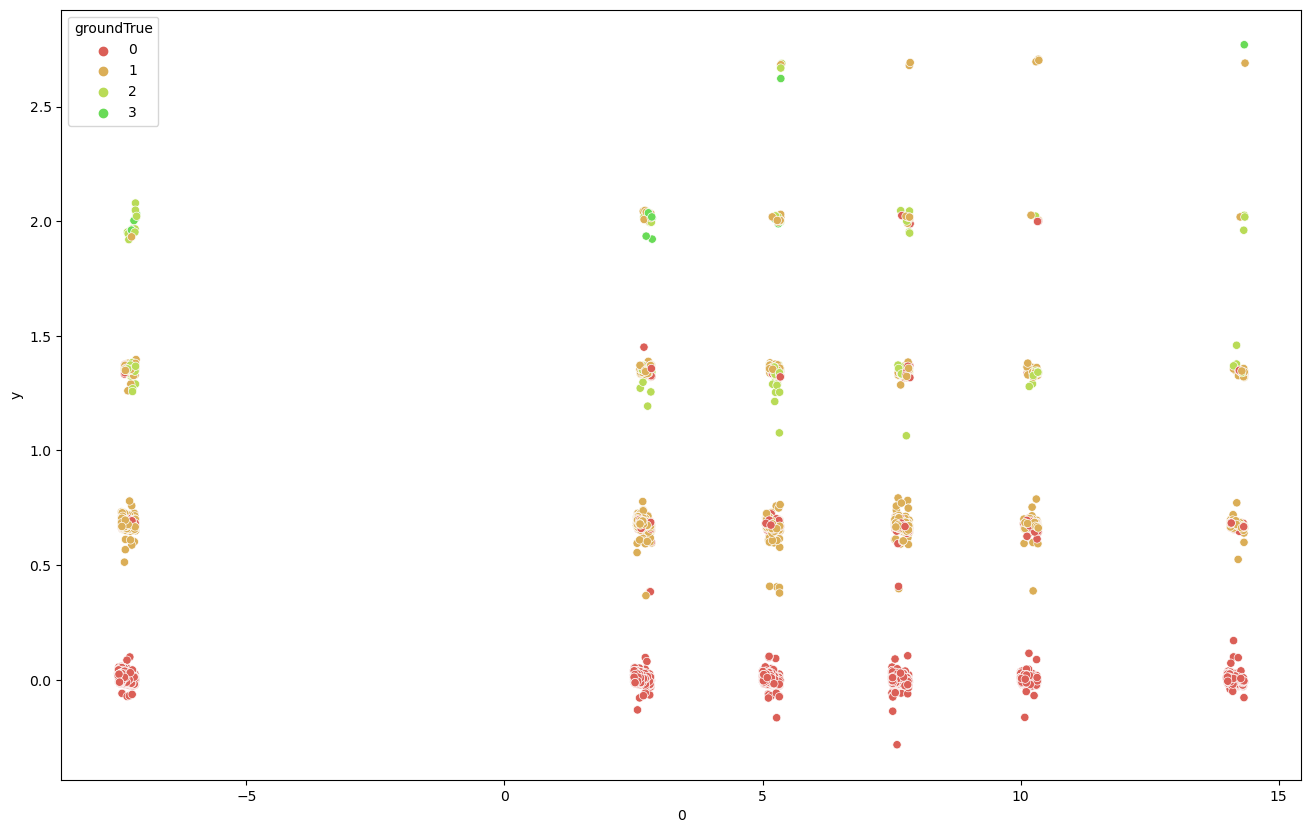

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y='y',
    hue="groundTrue",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=1
)

In [ ]:

hard_result = np.round(preds)

print(classification_report(test_y, hard_result))